## Image Registration: performance checks

This notebook demonstrates use of [Scikit-rt](https://github.com/scikit-rt/scikit-rt) for performing and checking image registration with [elastix](https://elastix.lumc.nl), [MATLAB](https://mathworks.com/help/matlab/) via [matlab-skrt](https://github.com/kh296/matlab-skrt), and [NiftyReg](http://cmictig.cs.ucl.ac.uk/wiki/index.php/NiftyReg).

### 1. Initial setup

To run this notebook, it needs to be on a machine that
has [Scikit-rt](https://github.com/scikit-rt/scikit-rt), and at least one
of the supported registration engines, as outlined in
the [installation instructions](https://scikit-rt.github.io/scikit-rt/installation.html).

Code in the cell below may need to be modified:

- `engine_dir` should be defined so that keys identify the installed registration
  engines ("elastix", "matlab", and/or "niftyreg"), and associated values are paths to
  the directories containing the software;
- `outdir` should be a path to a writeable directory,
  to be used for registration output.

In [1]:
# Import required classes and functions.
from pathlib import Path

from skrt import Defaults, Patient, Registration, SyntheticImage
from skrt.better_viewer.options import set_viewer_options
from skrt.core import fullpath
from skrt.registration import get_engines, get_parameters

# Set paths to directories containing registration software.
engine_dirs = {
    "elastix": "/opt/elastix-5.1.0",
    "niftyreg": "/opt/NiftyReg",
}

# Set paths for MATLAB image registration, based on value of matlabreg:
# - True: use matlabreg executable, with MATLAB runtime environment;
# - False: use mskrt package, with MATLAB executable;
# - any other value: no setup for "matlab" registration engine.
matlabreg = False
if matlabreg is True:
    engine_dirs["matlab"] = "/opt/matlabreg.app/Contents/MacOS"
    Defaults().matlab_runtime = "/Applications/MATLAB/MATLAB_Runtime/R2023a"
elif matlabreg is False:
    engine_dirs["matlab"] = "/opt/matlab-skrt"
    Defaults().matlab_app = "/Applications/MATLAB_R2023a.app/bin"
        
engines = get_engines(engine_dirs, verbose=True)

# Set path to directory to be used for registration output.
outdir = "registration_results/synthetic"

# In place of interactive images, display static graphics that can be saved with notebook.
# Defaults().no_ui = True
# Omit user part of paths when printing object attributes.
# Defaults().compress_user = True

Available registration engines: ['elastix', 'matlab', 'niftyreg']


### 2. Display options

Scikit-rt provides a large number of options for customising image display, both directly (see documentation for [better_viewer package](https://scikit-rt.github.io/scikit-rt/skrt.better_viewer.html#module-skrt.better_viewer), and indirectly, via Matplotlib [plot options](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html) and [runtime configuration](https://matplotlib.org/stable/tutorials/introductory/customizing.html).
Some of the possibilities are demonstrated in [plotting_demo.ipynb](https://github.com/scikit-rt/scikit-rt/blob/master/examples/notebooks/plotting_demo.ipynb).

Code in the cell below aims to set reasonable display options, but you can
replace this with something different.

In [2]:
# Set default Matplotlib runtime configuration,
# and obtain default options that can be passed to `view()` methods.
options = set_viewer_options(to_exclude="figsize", usetex=False);

### 3. Synthetic images for registration

Example synthetic images for registration are defined in the code cell below.  These may be replaced by other synthetic images (see some possibilities in: [simulation module](https://scikit-rt.github.io/scikit-rt/skrt.simulation.html)) or by [DICOM](https://www.dicomstandard.org/) or [NIfTI](https://nifti.nimh.nih.gov/) image data loaded as [Image](https://scikit-rt.github.io/scikit-rt/skrt.image.html#skrt.image.Image) objects.

In [3]:
# Fixed image for registration, featuring sphere of radius 30 mm,
# centred on image centre.
fixed = SyntheticImage(shape=(101, 101, 101), origin=(-50, -50, -50))
fixed.add_sphere(radius=30, name="sphere", centre=fixed.get_centre(), intensity=100)

# Moving image for registration, featuring cube of side length 40 mm,
# offset from image centre by (dx, dy, dz).
moving = SyntheticImage(shape=(101, 101, 101), origin=(-50, -50, -50))
dx, dy, dz = (4, -4, 2)
moving.add_cube(side_length=40, name="cube", centre=(dx, dy, dz), intensity=100)

### 3. Define and run registrations.

Registrations are run as sequences of steps.  For details of the parameters used in defining the registration steps, see documentation for the [Registration](https://scikit-rt.github.io/scikit-rt/skrt.registration.html#skrt.registration.Registration) class.

The examples here use parameter files included in the scikit-rt package for elastix and NiftyReg.  Functions have been defined for listing the predefined parameter files for a given registration engine, and for loading their contents to a dictionary, given either a full path or a pattern to match. 

```
from skrt.registration import get_default_pfiles, get_parameters, read_parameters

# List predefined parameter files for NiftyReg.
pfiles = get_default_pfiles(engine="niftyreg")
print(pfiles)

# List contents of one of the parameter files, given the file path.
params1 = read_parameters(pfiles[0])
print(params1)

# List contents of one of the parameter files, given a pattern to match.
params2 = get_parameters("*BSpline05*", "niftyreg")
print(params2)
```

For MATLAB, the image-registration function to call for a given step is defined by the dictionary `{"exe": <function_names>}`, where the available function names are:

- [imregdeform](https://uk.mathworks.com/help/medical-imaging/ref/imregdeform.html)
- [imregdemons](https://uk.mathworks.com/help/images/ref/imregdemons.html)
- [imregmoment](https://uk.mathworks.com/help/medical-imaging/ref/imregmoment.html)
- [imregtform](https://uk.mathworks.com/help/images/ref/imregtform.html)

Keyword-value pairs accepted by a function may be added to the dictionary to use values different from the default, for example:

```
pfiles["matlab"] = {"exe": "imregdeform", "GridRegularization": 0.001}
```

In [4]:
# Define engine-specific registration parameters.
pfiles = {
    "elastix": {"bspline": get_parameters("*BSpline05*", "elastix")},
    "matlab": {"deform": {"exe": "imregdeform"}},
    "niftyreg": {"bspline": get_parameters("*BSpline05*", "niftyreg")},
}

# Define and run registrations
registrations = {}
for engine in engines:
# Create object defining registration steps.
    registrations[engine] = Registration(
        engine=engine,
        engine_dir=engine_dirs[engine],
        initial_alignment=(dx, dy, dz),
        fixed=fixed,
        moving=moving,
        pfiles=pfiles[engine],
        path=Path(outdir) / engine,
        overwrite=True,
        capture_output=True,
        log_level='INFO',)

for reg in registrations.values():
    reg.register()
    
# For each registration step, obtain transformed grid, Jacobian determinant, and deformation field.
# Results are stored with the Registration object.
# They can subsequently be displayed, without needing to be recalculated.
    for step in reg.steps[-1:]:
        reg.get_transformed_grid(step, spacing=(10,10,10), thickness=(2, 2, 2), color='green', force=True)
        reg.get_jacobian(step)
        reg.get_deformation_field(step)

### 4. Display initial images

The pre-registration images (the same for elastix and NiftReg) are displayed and compared.  The default is to show the `x-y` slice at `z = 0`. 


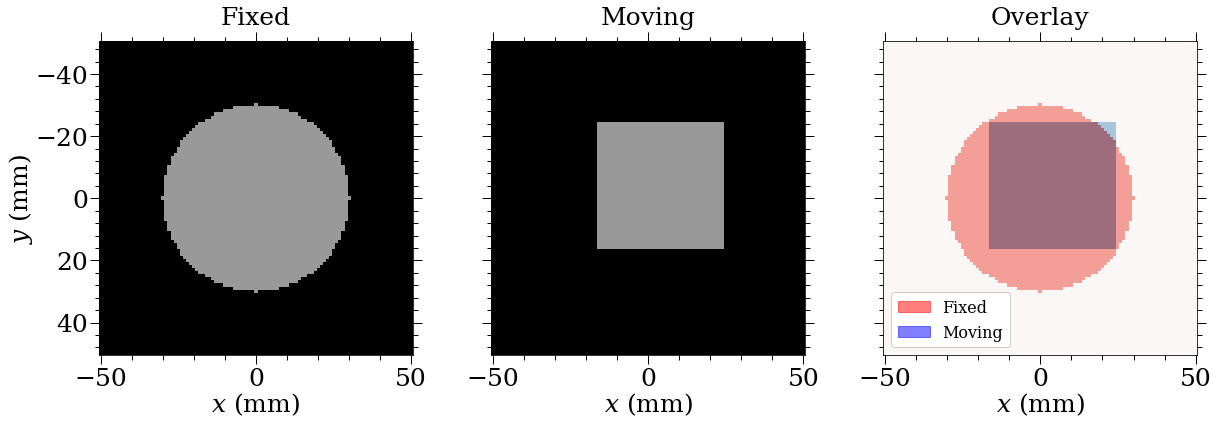

In [5]:
# Display initial images.
reg.view_init(overlay_legend=True, **options)

### 5. Display registration result

The (unaltered) fixed image and transformed moving image are displayed and compared.

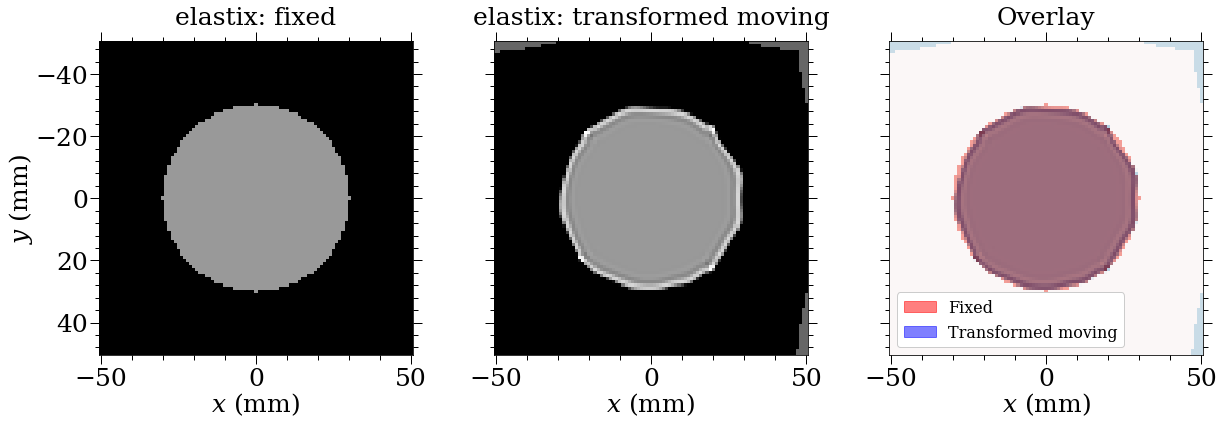

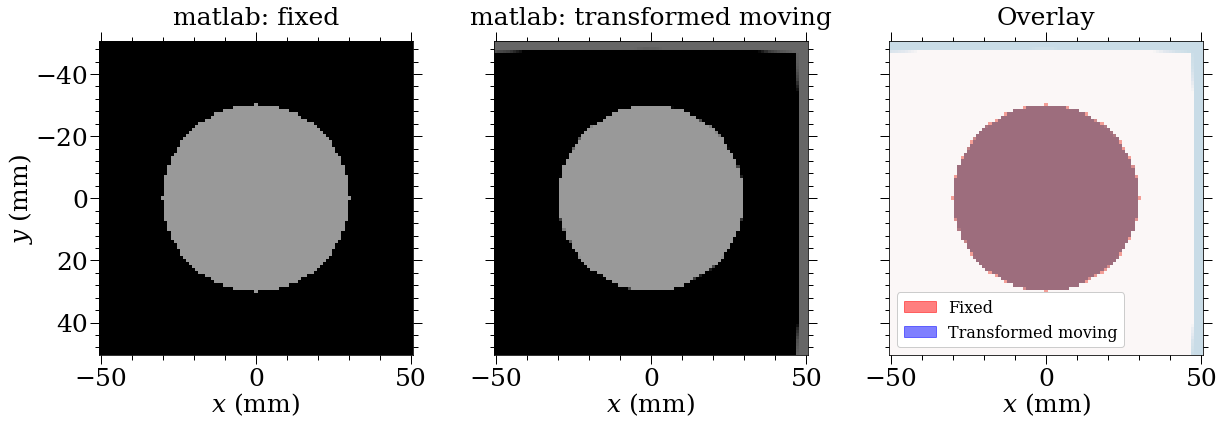

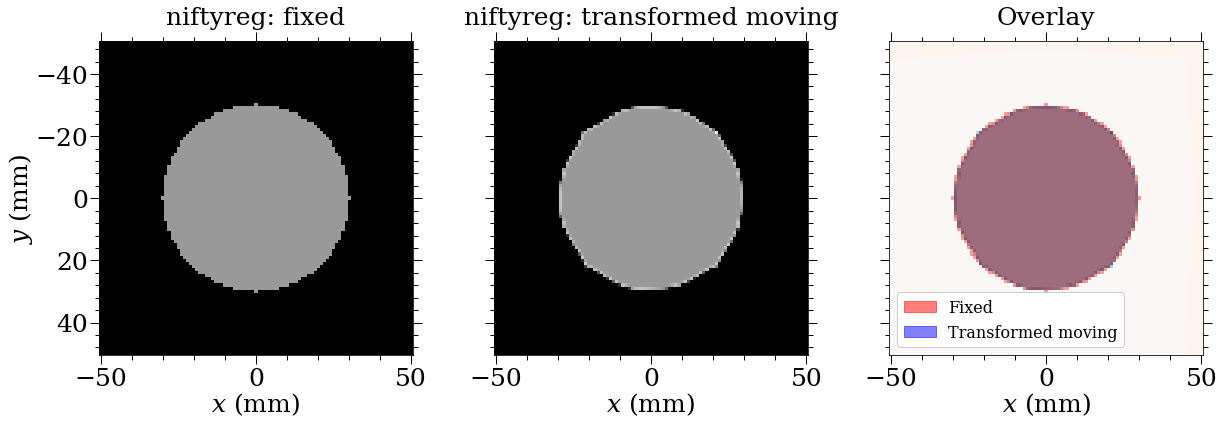

In [6]:
for engine, reg in registrations.items():
    titles = [f"{engine}: {title}" for title in ["fixed", "transformed moving"]]
    reg.view_result(overlay_legend=True, title=titles, **options)

### 6. Transformed grid

The moving image and an initially regular grid are displayed after application of the transform calculated at each step in the registration.  This show the effect of pulling grid points from the space of the moving image to the space of the fixed image.

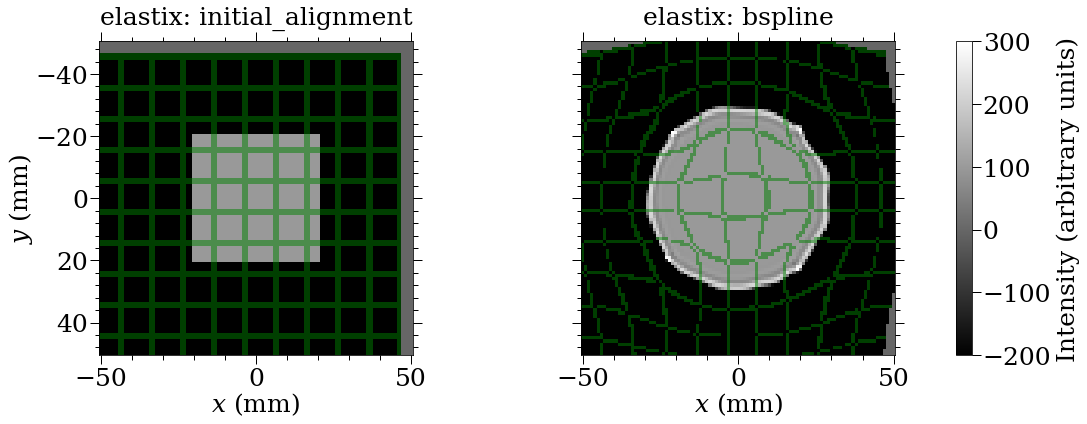

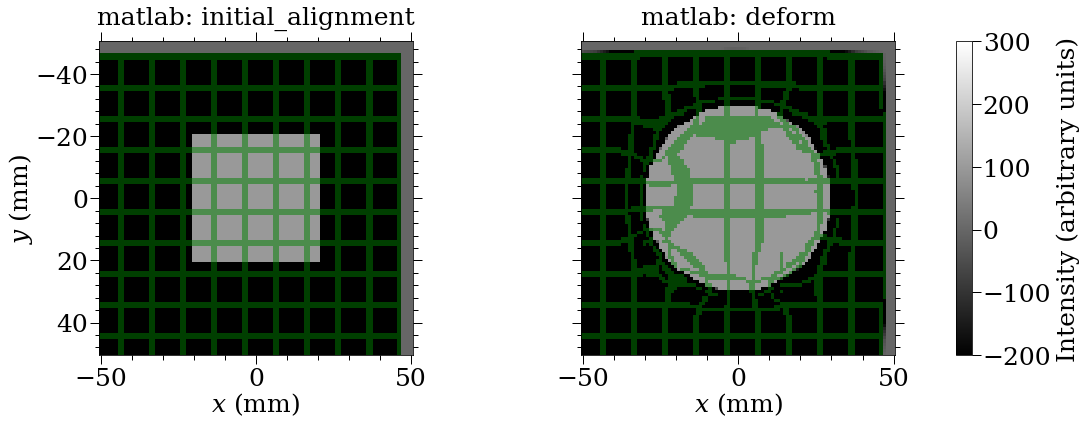

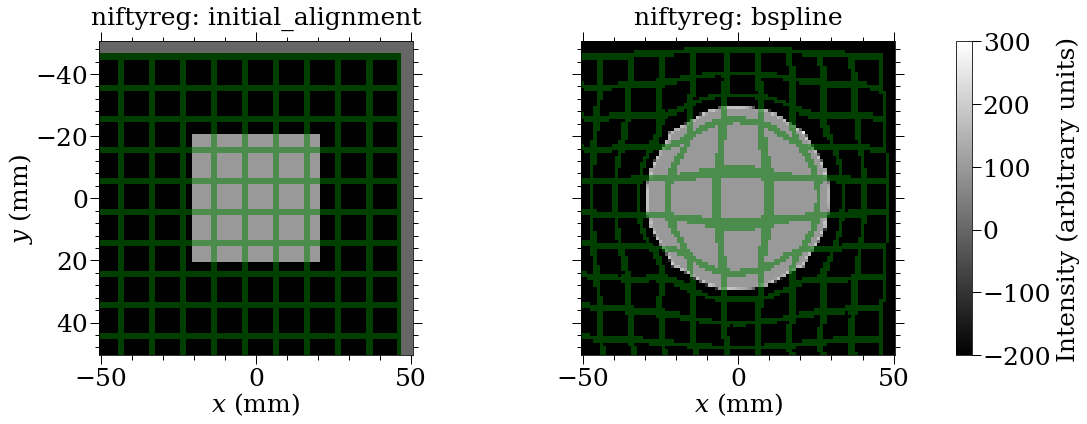

In [7]:
for engine, reg in registrations.items():
    reg.transformed_images[reg.steps[0]].view(
        images=[reg.transformed_images[step] for step in reg.steps[1:]],
        grid=[reg.get_transformed_grid(step) for step in reg.steps],
        title=[f"{engine}: {step}" for step in reg.steps],
        colorbar=1, colorbar_label="Intensity (arbitrary units)", grid_opacity=0.5, figsize=(21, 6), **options);

### 7. Display Jacobian determinant

The registration's Jacobian determinant shows how volumes change locally in mapping from the *fixed* image to the *moving* image.  Positive values define a scaling factor: values greater than 1 indicate expansion; values less than 1 indicate contraction.  Negative values indicate folding.

For non-deformable registration, the Jacobian determinant is defined by elastix with a value of 1 everywhere, and is undefined by NiftyReg.

The Jacobian determinant isn't calculated for registrations by MATLAB.

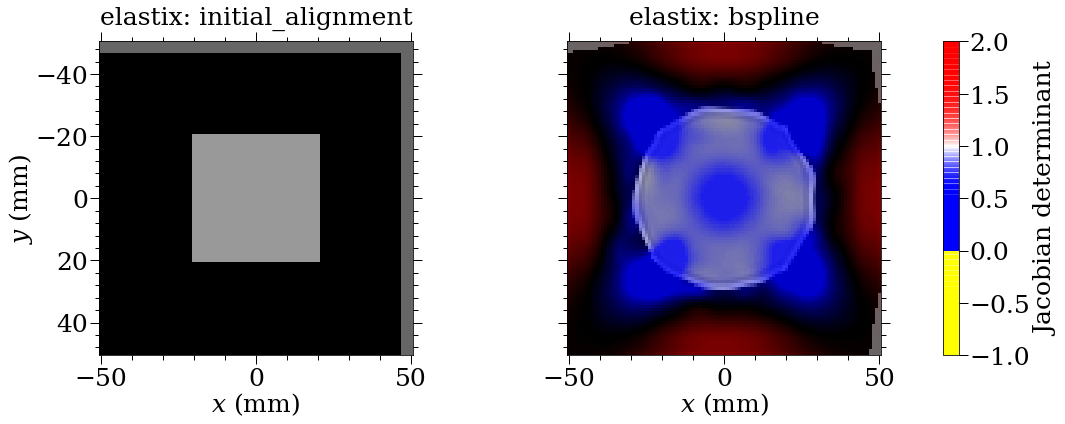

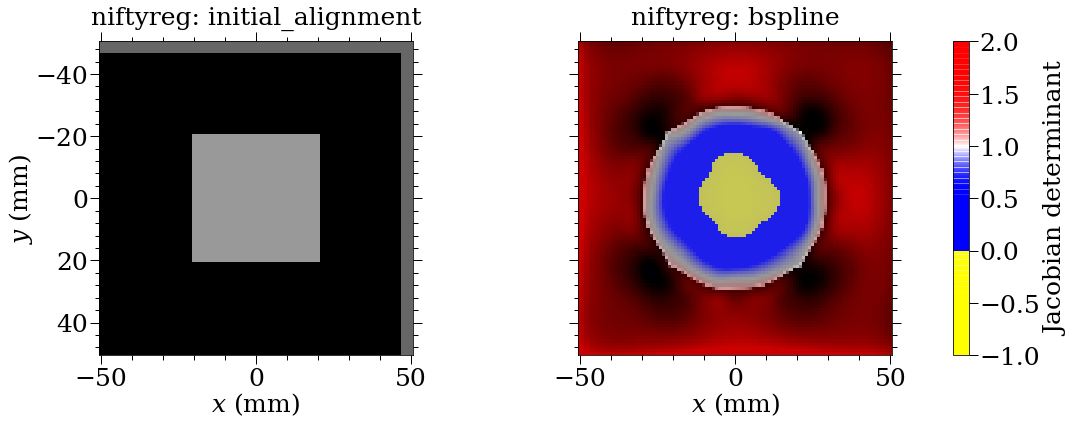

In [8]:
# For axes, set spacing (pad) and size of label and title
for engine, reg in registrations.items():
    if "matlab" == engine:
        continue
    reg.transformed_images[reg.steps[0]].view(
        images=[reg.transformed_images[step] for step in reg.steps[1:]],
        jacobian=[reg.get_jacobian(step) for step in reg.steps],
        title=[f"{engine}: {step}" for step in reg.steps],
        colorbar=-1, figsize=(21, 6), **options);

### 8. Display information from deformation field

The registration's deformation field is represented by a four-dimensional array.  For each voxel in the (three-dimensional) fixed image, this defines a (three-component) vector defining the displacement in mapping from the *fixed* image to the *moving* image.

(The deformation field referred to here is as defined for elastix (see section 4.2 of [elastix: the manual](https://elastix.lumc.nl/download/elastix-5.1.0-manual.pdf).  For NiftyReg this is the displacement field (see [reg_transform documentation](http://cmictig.cs.ucl.ac.uk/wiki/index.php/Reg_transform)).

#### 8.1 Maximum displacements

In a translation step, maximum displacements reflect offsets of image features in the moving image relative to the corresponding features in the fixed image.  In affine and b-spline steps, maximum displacements can relate to volume changes or shape changes.

The initial alignment in the registration is a user-defined translation.  It has been defined here to match the known feature offset, as reflected in the results: maximum displacements for the initial-alignment step exactly match the feature offset.

In [9]:
form = ".2f"
print(f"Original offsets of sphere centroid relative to cube centroid: dx = {dx:{form}}, dy = {dy:{form}}, dz = {dz:{form}}")

for engine, reg in registrations.items():
    for step in reg.steps:
        displacements = {}
        for xyz in ["x", "y", "z"]:
            displacements[xyz] = reg.get_deformation_field(step).get_displacement_image(xyz).get_data().max()
        print(f"{engine} - {step}: dx = {displacements['x']:{form}}, dy = {displacements['y']:{form}}, dz = {displacements['z']:{form}}")

Original offsets of sphere centroid relative to cube centroid: dx = 4.00, dy = -4.00, dz = 2.00
elastix - initial_alignment: dx = 4.00, dy = -4.00, dz = 2.00
elastix - bspline: dx = 15.27, dy = 7.39, dz = 13.60
matlab - initial_alignment: dx = 4.00, dy = -4.00, dz = 2.00
matlab - deform: dx = 21.06, dy = 8.71, dz = 19.16
niftyreg - initial_alignment: dx = 4.00, dy = -4.00, dz = 2.00
niftyreg - bspline: dx = 13.65, dy = 5.67, dz = 11.66


#### 8.2 Quiver plots

Quiver plots show the two-dimensional displacements, in the slice and orientation viewed, for mapping points from the fixed image to the moving image.  Arrow lengths and (by default) colours represent displacement magnitudes.

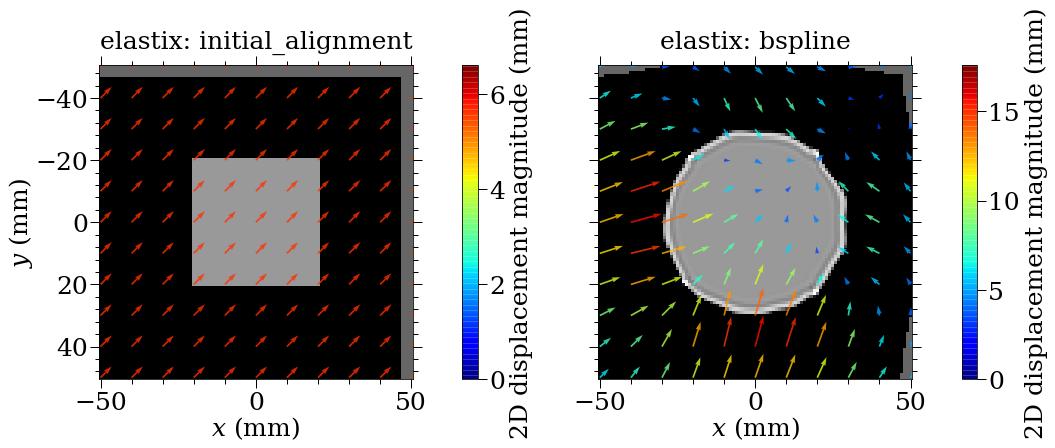

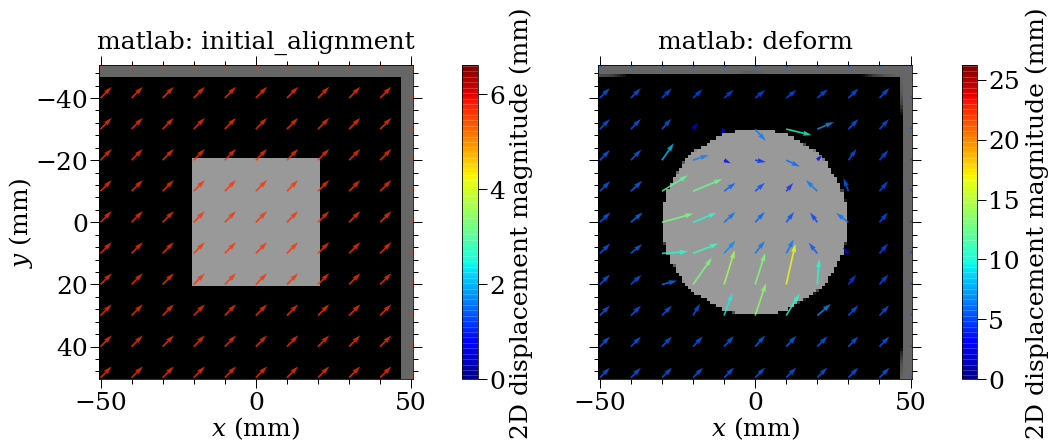

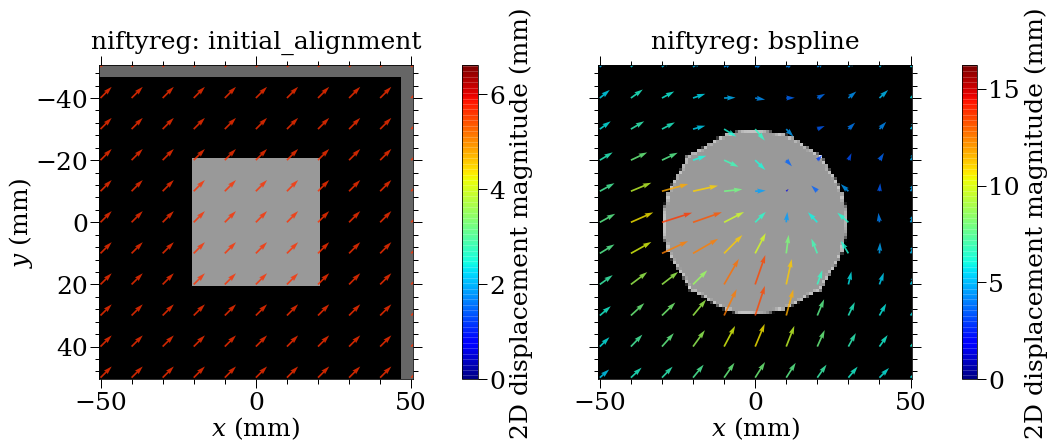

In [10]:
for engine, reg in registrations.items():
    reg.transformed_images[reg.steps[0]].view(
        images=[reg.transformed_images[step] for step in reg.steps[1:]],
        df=[reg.get_deformation_field(step) for step in reg.steps], df_spacing=10,
        title=[f"{engine}: {step}" for step in reg.steps], df_plot_type="quiver", df_opacity=0.8,
        colorbar=-1, figsize=(21, 6), colorbar_last_only=False, **options);

#### 8.3 Deformation grid

The deformation grid at each step in the registration shows how points on a grid in the space of the fixed image are pushed to the moving image.  This means that it shows the effect of transformations in the direction opposite from the transformed grid (section 6 above).

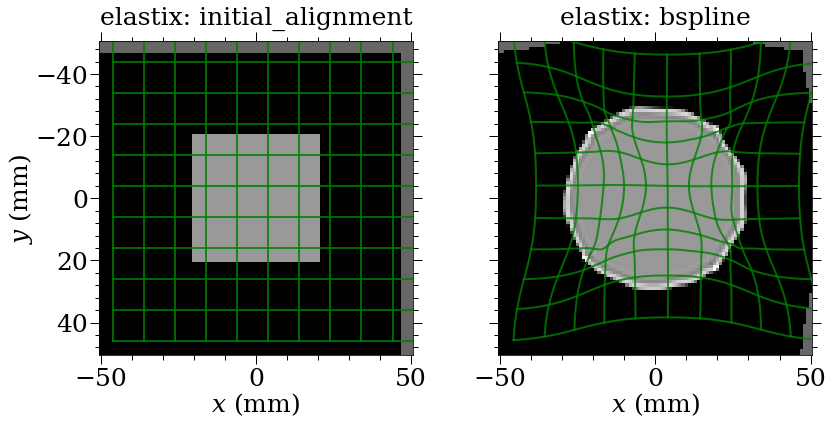

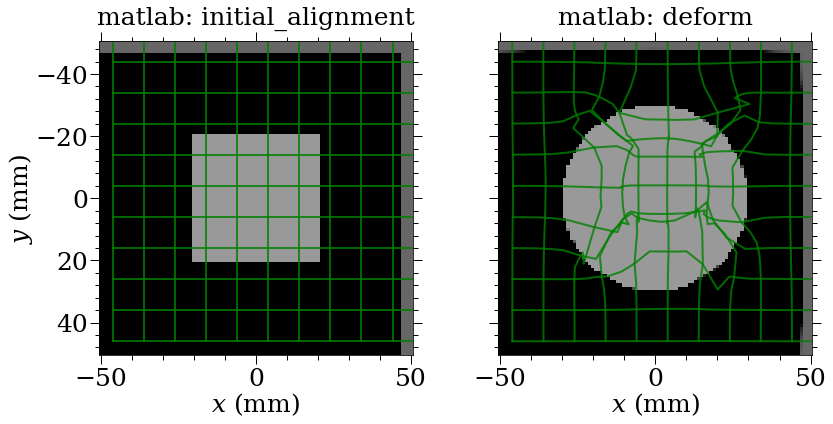

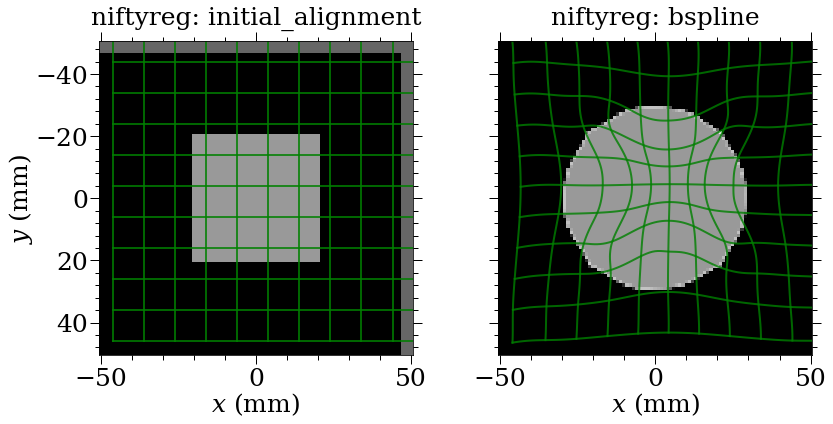

In [11]:
for engine, reg in registrations.items():
    reg.transformed_images[reg.steps[0]].view(
        images=[reg.transformed_images[step] for step in reg.steps[1:]],
        df=[reg.get_deformation_field(step) for step in reg.steps], df_spacing=10,
        title=[f"{engine}: {step}" for step in reg.steps], df_plot_type="grid", df_opacity=0.8,
        colorbar=-1, figsize=(21, 6), colorbar_last_only=False, **options);

#### 8.4 One-dimensional displacements

A plot of one-dimensional displacements shows the displacements along the `x`, `y`, or `z` axis in mapping from fixed image to moving image.

For translations, displacements are the same everywhere, so that plots have an
overlay of uniform colour (different depending on the direction considered).  Final displacements here are the result of the initial-alignment translation plus deformations.  The effect of the latter is that negative displacements become less negative and positive displacements become less positive: the region occupied by the sphere in the fixed image is compressed to occupy a smaller region when mapped to the moving image.

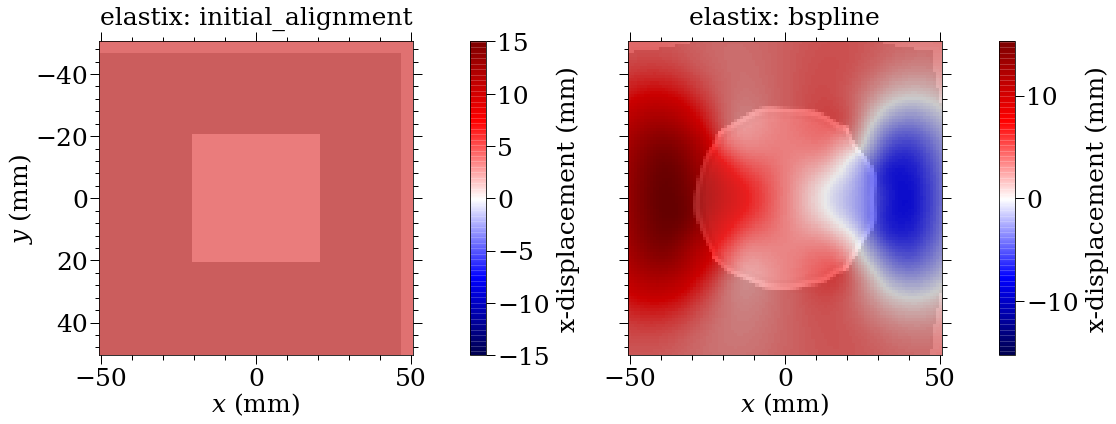

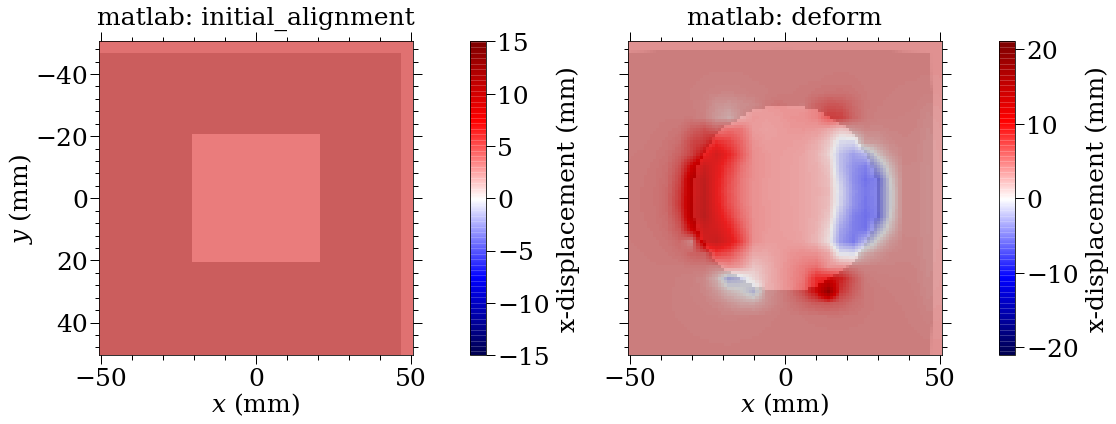

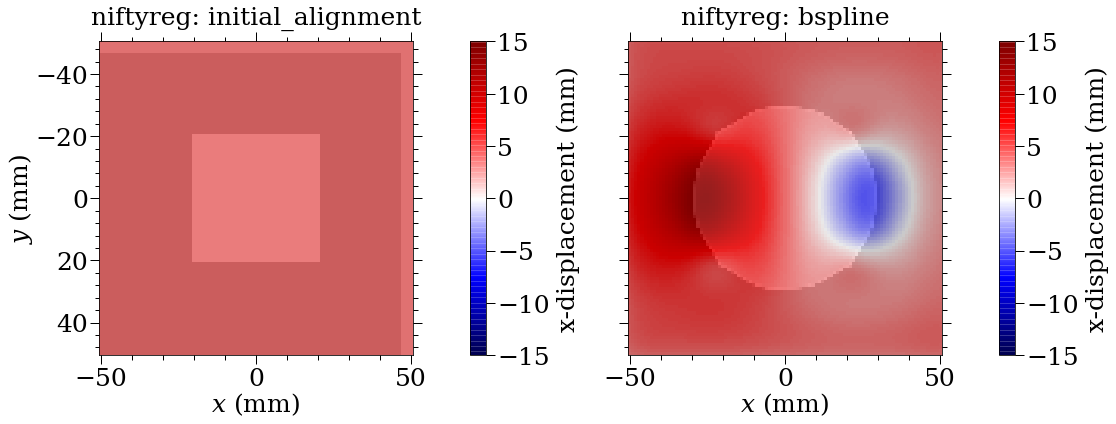

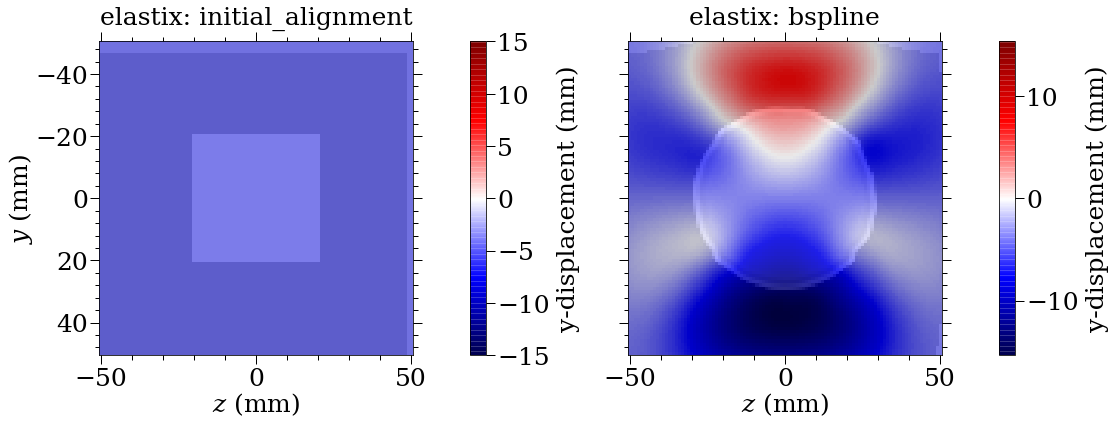

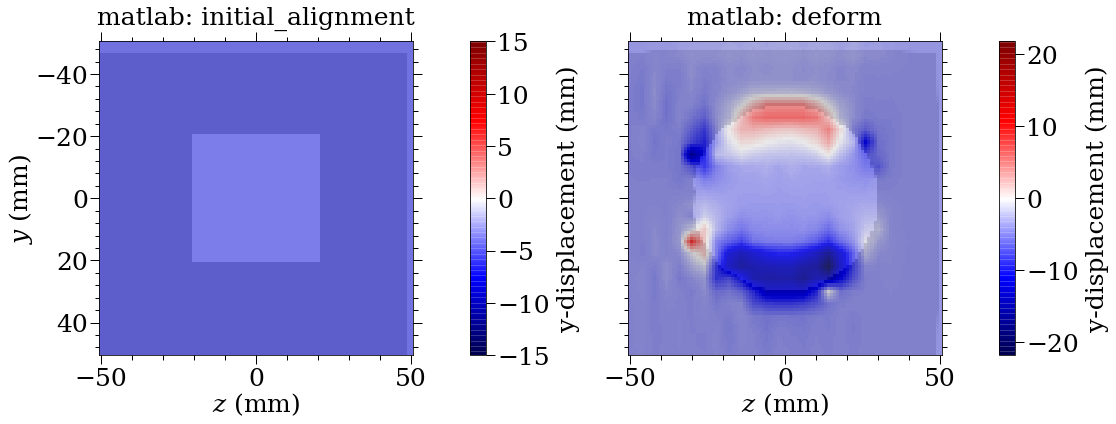

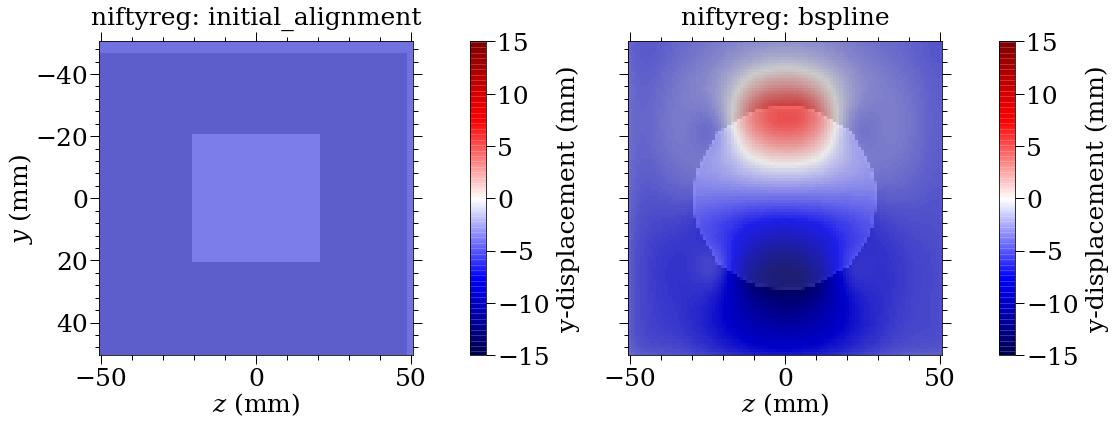

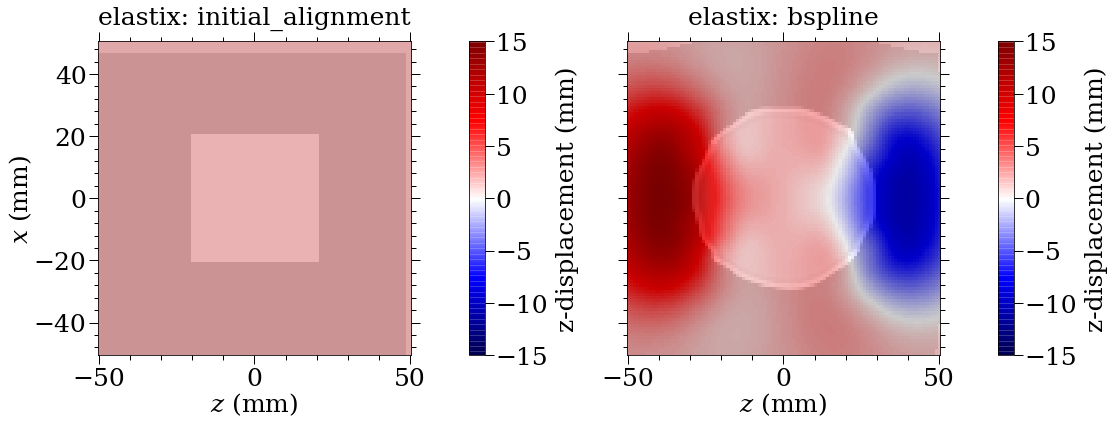

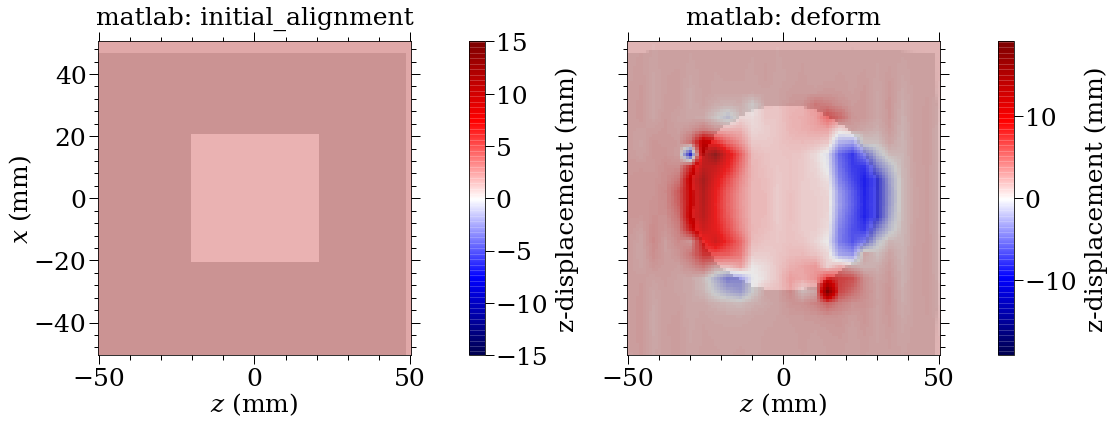

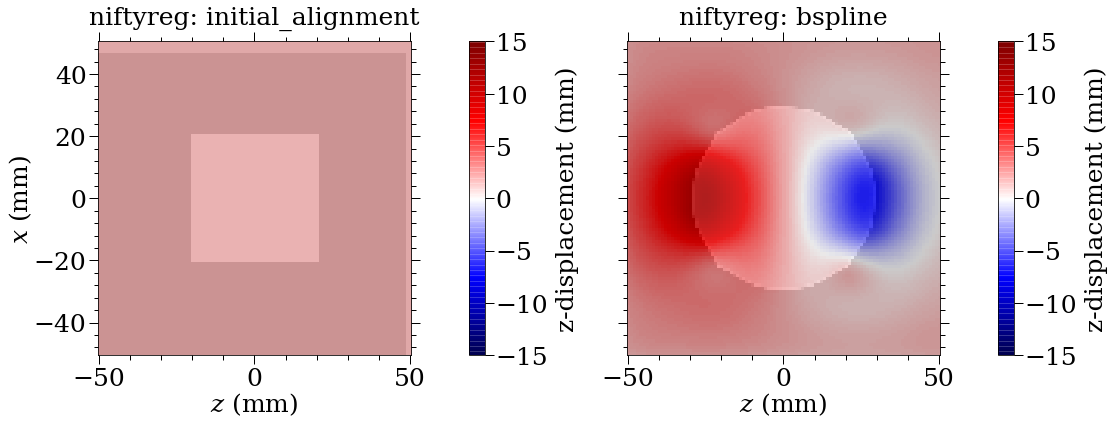

In [12]:
options["clb_kwarg"] = {"pad": 0.05}
init_views = {"x": "x-y", "y": "z-y", "z": "z-x"} 

for xyz in ["x", "y", "z"]:
    for engine, reg in registrations.items():
        reg.transformed_images[reg.steps[0]].view(
            images=[reg.transformed_images[step] for step in reg.steps[1:]],
            df=[reg.get_deformation_field(step) for step in reg.steps], df_spacing=10,
        title=[f"{engine}: {step}" for step in reg.steps], df_plot_type=f"{xyz}-displacement", df_opacity=0.8,
            colorbar=-1, figsize=(21, 6), colorbar_last_only=False,
            init_view=init_views[xyz], **options)

#### 8.5 Three-dimensional displacement magnitudes

A plot of three-dimensional displacement magnituds shows the magnitudes of the three-dimensional displacement vectors for the registration's mapping from fixed image to moving image.

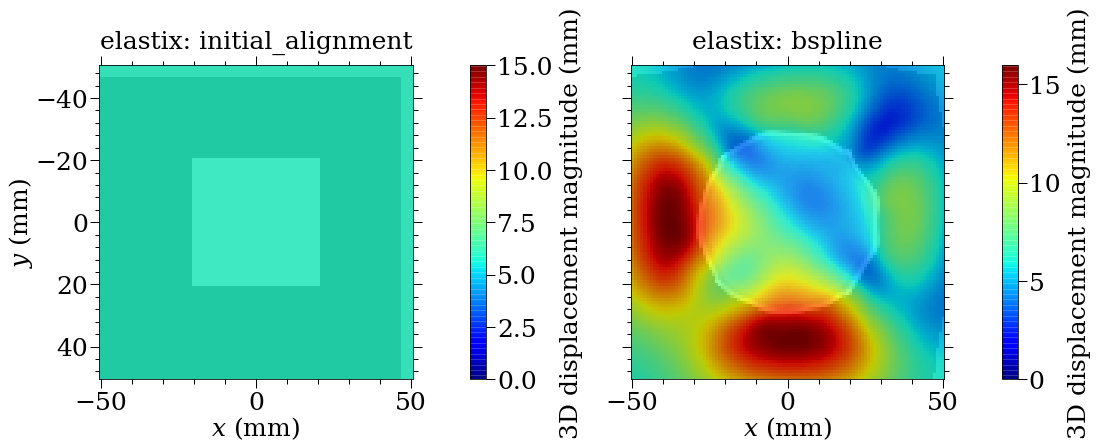

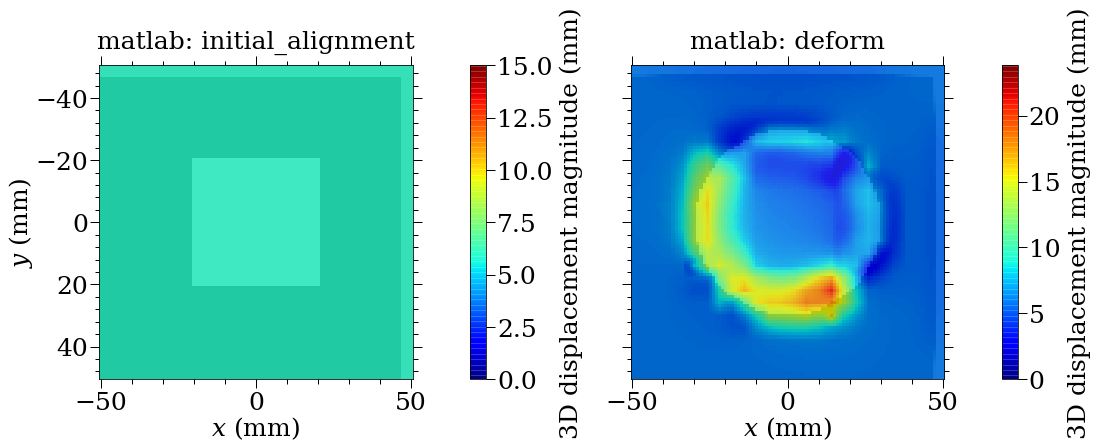

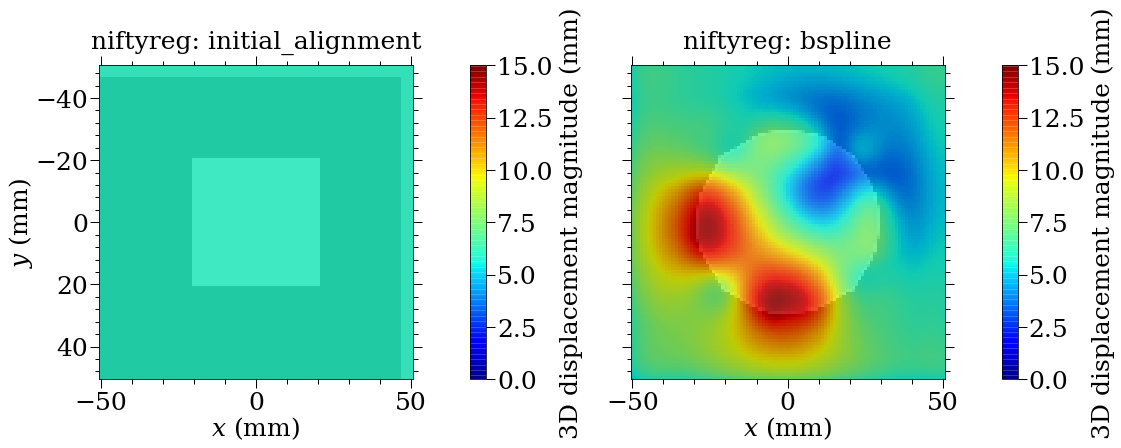

In [13]:
for engine, reg in registrations.items():
    reg.transformed_images[reg.steps[0]].view(
        images=[reg.transformed_images[step] for step in reg.steps[1:]],
        df=[reg.get_deformation_field(step) for step in reg.steps], df_spacing=10,
        title=[f"{engine}: {step}" for step in reg.steps], df_plot_type="3d-displacement",
        df_opacity=0.8, colorbar=-1, figsize=(21, 6), colorbar_last_only=False,
        **options, df_kwargs={"vmin": 0, "cmap": "jet"});